In [1]:
from pathlib import Path

from main import MAE

from dataclasses import dataclass

import numpy as np
import matplotlib.pyplot as plt

from skimage import io

import pandas as pd

In [2]:
import torch

In [3]:
import attention_map_things

In [4]:
import seaborn as sns

## Load the model

Pre-trained model

In [6]:
model_path = 'Path_to_the_MAE_model'
model = MAE.load_from_checkpoint(model_path)
model.eval()
backbone = model.backbone

 ## Open roi image

In [ ]:
channel_paths = [] # Should be in order of 'r1_DAPI', 'r1_AF488', 'r1_AF555', 'r1_AF647', 'r1_AF750', 'r2_AF647', 'r2_AF750'
image = []
for chp in channel_paths:
    image.append(io.imread(chp))
image = np.stack(image, axis=0)

In [51]:
@dataclass
class dummy_dataclass:
    input_size = 224
    overlap = 112
    dataset = '' # Dataset name
    data_path = '' # Datapath
args = dummy_dataclass()

In [52]:
marker_names = ['Nuclei', 'PDGFRB', 'PDGFRA', 'SMA', 'FAP', 'Epithelia']

Visualize channels

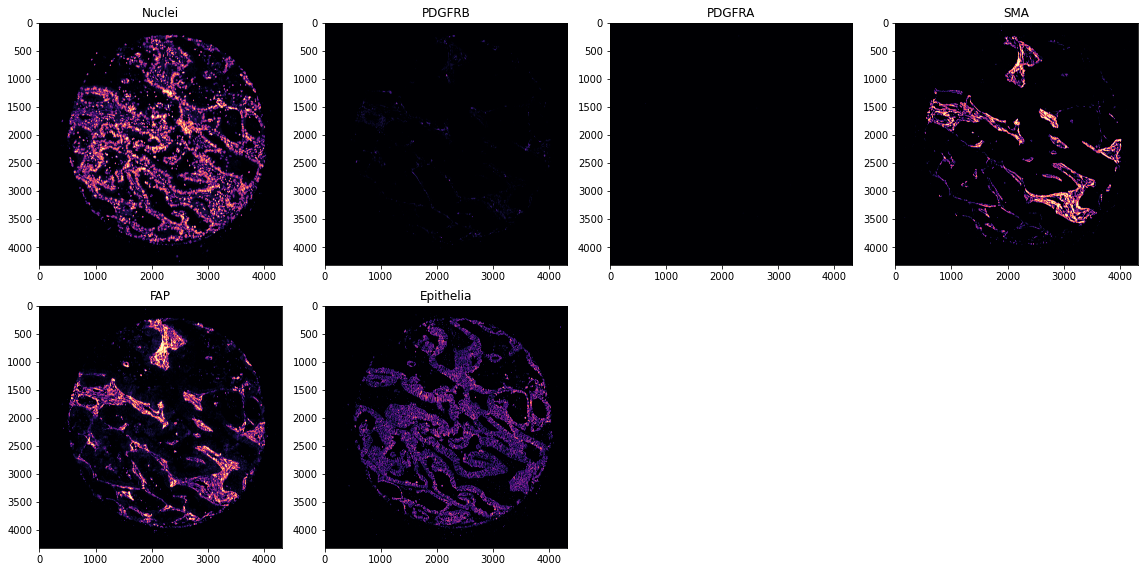

In [53]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
for i, ax in enumerate(axes.flat):
    if i >= image.shape[0]:  # Use image.shape directly if image is already in a 2D format
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_frame_on(False)
        continue

    # Clip the image based on the first channel's median and quantile, or modify this if necessary
    clipped_image = np.clip(image[i], np.median(image[0]), np.quantile(image[0], 0.99))
    
    ax.imshow(clipped_image, cmap='magma')
    ax.set_title(marker_names[i])
    ax.grid(False)

plt.tight_layout()
plt.show()

## Get attentions

In [54]:
attention_maps = attention_map_things.get_attention(image, backbone, args)

In [56]:
thattn = []
for attn in attention_maps:
    quantilecut = np.quantile(attn, 0.7)
    upperquantilecut = np.quantile(attn, 0.99)
    attn = np.clip(attn, a_min=quantilecut, a_max=upperquantilecut)
    thattn.append(attn)
thattn = np.stack(thattn, axis=0)

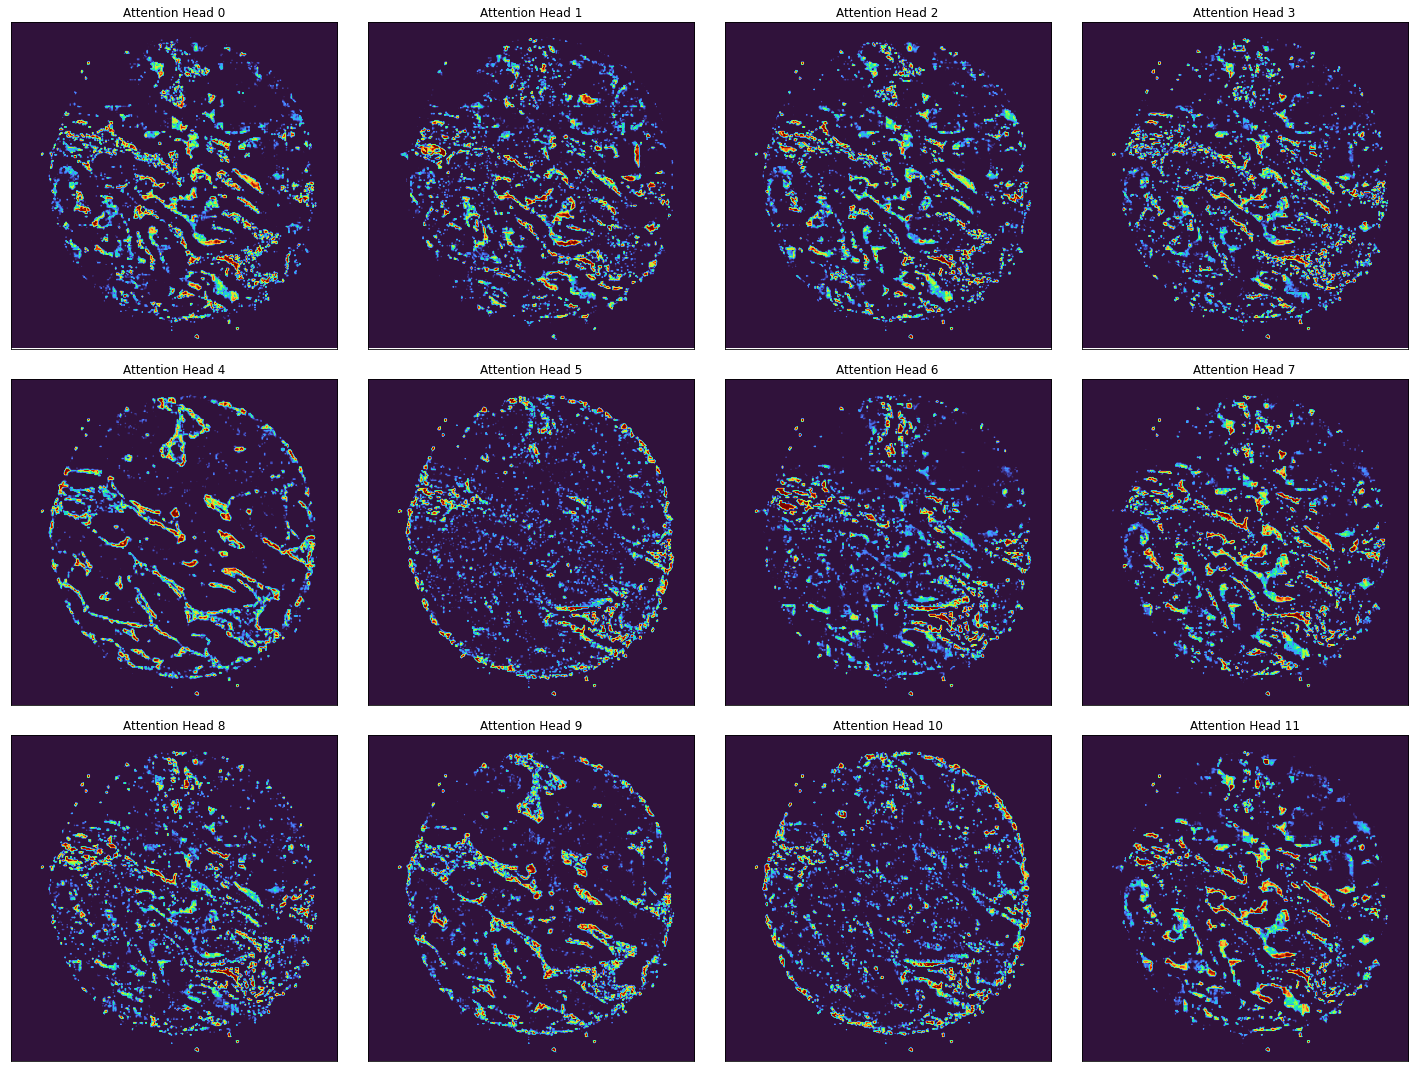

In [58]:
# Plot each attention head
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))
for i, ax in enumerate(axes.flat):
    pp = (thattn[i] - thattn[i].min()) / (thattn[i].max() - thattn[i].min())
    im = ax.imshow(pp, cmap='turbo')
    ax.set_title(f'Attention Head {i}')
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    # fig.colorbar(im, ax=ax)  # Add color bar to each subplot
fig.tight_layout()
plt.show()

# Pearson correlation

In [61]:
attention_maps.shape, image.shape

((12, 4320, 4320), (6, 4320, 4320))

In [62]:
imagetn = []
for attn in image:
    lowerquantilecut, upperquantilecut = np.quantile(attn, [0.5, 0.99])
    iimgth = np.clip(attn, a_min=lowerquantilecut, a_max=upperquantilecut)
    imagetn.append(iimgth)
imagetn = np.stack(imagetn, axis=0)
thattn = []
for attn in attention_maps:
    quantilecut, upperquantilecut = np.quantile(attn, [0.8, 0.99])
    attn = np.clip(attn, a_min=quantilecut, a_max=upperquantilecut)
    thattn.append(attn)
thattn = np.stack(thattn, axis=0)

In [63]:
x = torch.cat([torch.from_numpy(imagetn.astype('int16')).flatten(1,2), 
               torch.from_numpy(thattn).flatten(1,2)
              ],
              dim=0)
x.shape

torch.Size([18, 18662400])

In [64]:
pearsoncorrs = torch.corrcoef(x)

torch.Size([18, 18])

In [65]:
pearsondf = pd.DataFrame(pearsoncorrs)
pearsondf.index = marker_names + [f'Attn {i}' for i in range(len(thattn))]
pearsondf.columns = marker_names + [f'Attn {i}' for i in range(len(thattn))]

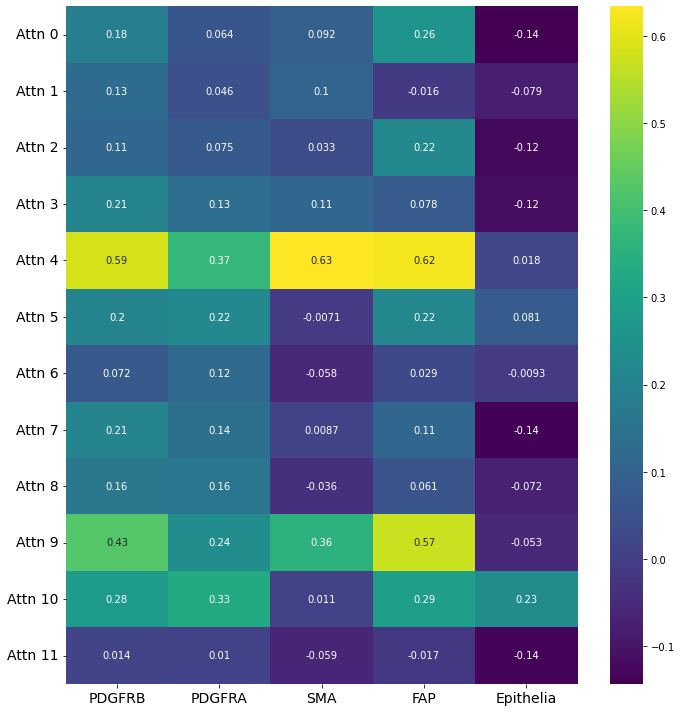

In [66]:
plt.figure(figsize=(10,10))
sns.heatmap(data=pearsondf.loc['Attn 0':'Attn 11', 'PDGFRB':'Epithelia'], cmap='viridis', annot=True)

plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)

plt.tight_layout()
plt.show()

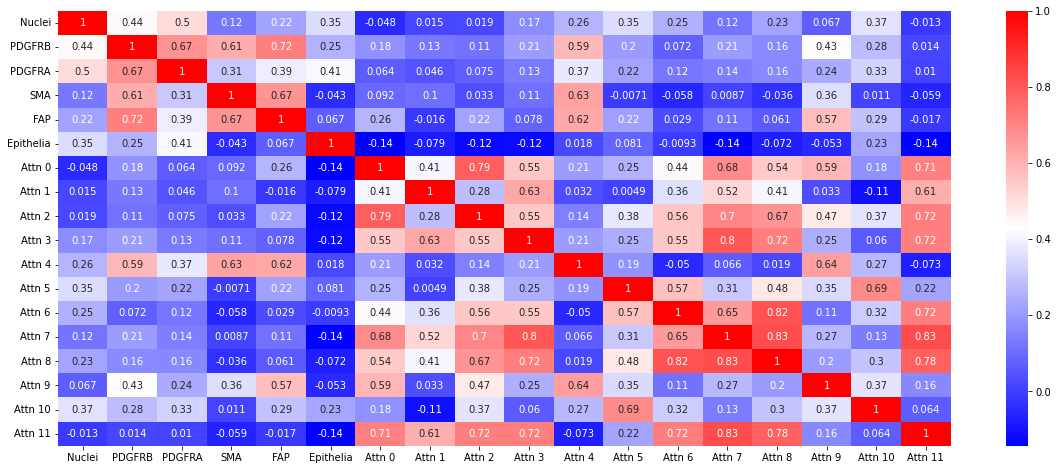

In [68]:
plt.figure(figsize=(20,8))
sns.heatmap(data=pearsondf, cmap='bwr', annot=True)
plt.show()